In [2]:
import keras
import numpy as np
import tensorflow as tf
from keras import layers
from sklearn.metrics import classification_report
from keras import layers, models, regularizers
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau
import keras_tuner as kt
from tensorflow.keras.metrics import Precision, Recall
import tensorflow.keras.backend as K
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import torch
import torchaudio
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV, train_test_split

2024-07-04 15:29:52.592134: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-04 15:29:52.612513: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-04 15:29:52.612558: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-04 15:29:52.627962: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [54]:
X = np.load('audio_features.npy')
y = np.load('audio_labels.npy')

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_formated = X_train
y_train_formated = y_train
X_test_formated = X_test
y_test_formated = y_test

In [3]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
import numpy as np
physical_devices = tf.config.list_physical_devices('GPU')


class AudioProcessor:
    def __init__(self, path_df, path_audio):
        self.path_df = "df_filter.csv"
        self.path_audio = path_audio
        self.load_data()

    def load_data(self):
        df = pd.read_csv(self.path_df)
        df["file_cut_path"] = self.path_audio + df["file_name"]
        df = df.reset_index(drop=True)
        self.dataset = df["file_cut_path"]

        self.log = []
        for i in range(len(df)):
            self.log.append(torch.load("torch_files14/" + f"torch_files14file{i}.pt"))

        self.y = df["label"]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.log, self.y, random_state=42, stratify=self.y
        )

        self.process_tensors()

    def process_tensors(self):
        for i in range(len(self.X_train)):
            self.X_train[i] = self.X_train[i][0].detach().numpy()
            self.X_train[i] = np.concatenate(self.X_train[i])

        for i in range(len(self.X_test)):
            self.X_test[i] = self.X_test[i][0].detach().numpy()
            self.X_test[i] = np.concatenate(self.X_test[i])

2024-07-04 15:29:55.579984: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-04 15:29:55.580965: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-04 15:29:55.581012: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.


In [4]:
processor = AudioProcessor(path_df="./df_filter.csv", path_audio="../audios/")
X_train   = processor.X_train
y_train  = processor.y_train
X_test = processor.X_test
y_test = processor.y_test

X_train_formated = np.array(X_train)
y_train_formated = np.array(y_train)
X_test_formated = np.array(X_test)
y_test_formated = np.array(y_test)

print("X_train_formated")
X_train_formated.shape
print("y_train_formated")
y_train_formated.shape
print("X_test_formated")
X_test_formated.shape
print("y_test_formated")
y_test_formated.shape


print("Datos cargados")

X_train_formated
y_train_formated
X_test_formated
y_test_formated
Datos cargados


In [57]:
print("Xtrain") 
X_train_formated.shape


Xtrain


(1794, 152576)

In [58]:
print("Ytrain") 
y_train_formated.shape

Ytrain


(1794,)

In [28]:
X_train = np.array(X_train)
X_train_formated = X_train.reshape((1794, 128, 1192)) 

timesteps = 128  # chosen timesteps
features = 1192  # calculated features per timestep
input_shape = (timesteps, features)
num_classes = 1  # assuming binary classification

In [31]:
model = models.Sequential([
    layers.Input(shape=(timesteps, features)), 
    layers.LSTM(64, return_sequences=True, input_shape=(128,input_shape)),
    layers.LSTM(32, return_sequences=False),
    layers.Dense(60, activation="relu", kernel_regularizer=regularizers.l2(0.02)),
    layers.Dropout(0.2),
    layers.Dense(30, activation="relu", kernel_regularizer=regularizers.l2(0.02)),
    layers.Dense(num_classes, activation="sigmoid")  # Capa de salida con activación sigmoid para binaria
])


In [33]:
model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    layers.Dense(60, activation="relu", kernel_regularizer=regularizers.l2(0.02)),
    layers.Dense(30, activation="relu", kernel_regularizer=regularizers.l2(0.02)),
    layers.Dense(num_classes, activation="sigmoid")  # Capa de salida con activación sigmoid
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model = models.Sequential([
    layers.Bidirectional(layers.LSTM(128, return_sequences=True), input_shape=(timesteps, features)),
    layers.Bidirectional(layers.LSTM(64, return_sequences=False)),
    
    layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(num_classes, activation="sigmoid")
])

In [ ]:
model = models.Sequential([
    # Añadir capas convolucionales para extraer características
    layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(timesteps, features)),
    layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.2),
    
    # Capas LSTM para capturar dependencias temporales
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(64, return_sequences=False),
    
    # Capas densas para la clasificación final
    layers.Dense(60, activation="relu", kernel_regularizer=regularizers.l2(0.02)),
    layers.Dropout(0.2),
    layers.Dense(30, activation="relu", kernel_regularizer=regularizers.l2(0.02)),
    layers.Dense(num_classes, activation="sigmoid")  # Capa de salida con activación sigmoid para clasificación binaria
])

In [40]:
model = models.Sequential([
    # Añadir capas Bidirectional LSTM
    layers.Bidirectional(layers.LSTM(128, return_sequences=True), input_shape=(timesteps, features)),
    layers.Bidirectional(layers.LSTM(64, return_sequences=False)),
    
    # Capas densas para la clasificación final
    layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.2),
    
    layers.Dense(num_classes, activation="sigmoid")  # Capa de salida con activación sigmoid para clasificación binaria
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [46]:
model = models.Sequential([
    # Añadir capas Bidirectional LSTM
    layers.Bidirectional(layers.LSTM(128, return_sequences=True), input_shape=(timesteps, features)),
    layers.Bidirectional(layers.LSTM(64, return_sequences=False)),
    
    # Capas densas para la clasificación final
    layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    
    layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    
    layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.2),
    
    layers.Dense(num_classes, activation="sigmoid")  # Capa de salida con activación sigmoid para clasificación binaria
])

In [ ]:
model = models.Sequential([
    layers.Flatten(input_shape=(152576,)),
    layers.Flatten(input_shape=input_shape),  # Aplanar la entrada para usar capas densas
    layers.Dense(64, activation="relu",),  # Primera capa densa con 128 neuronas
    layers.Dropout(0.25),
    layers.Dense(32, activation="relu"),  # Segunda capa densa con 64 neuronas
    layers.Dropout(0.5),
    layers.Dense(16, activation="relu"),  # Segunda capa densa con 64 neuronasºexit
  # Capa de salida con activación sigmoid para clasificación binaria
])

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
optimizer = keras.optimizers.Adam(learning_rate= 0.001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=1e-6,)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=0, patience=60)
model.compile(loss=loss, optimizer=optimizer ,metrics=['accuracy'])
model.summary()
# Train the model
history = model.fit(X_train_formated, y_train_formated, epochs=50, batch_size=2, validation_split=0.2, verbose=1, callbacks=[reduce_lr,early_stop])


In [ ]:
X_test_formated = X_test_formated.reshape((-1, 128, 1192))
y_pred = model.predict(X_test_formated, verbose=1)
y_pred_bool = np.round(y_pred)

loss, accuracy = model.evaluate(X_test_formated, y_test_formated)
y_test_formated_values=y_test_formated
y_pred_bool = np.where(y_pred_bool > 0.5, 1, 0).reshape(-1)
print(f'Loss: {loss}, Accuracy: {accuracy}')
print(classification_report(y_test_formated_values, y_pred_bool))

In [8]:


# Define the HyperModel
def build_model(hp):
    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling='log')
    model = keras.Sequential()
    for i in range(0, hp.Int("num_layers", 1, 6)):
        model.add(
            tf.keras.layers.Dense(units = hp.Int(f"unit_{i}", 15, 80, step = 5), 
                                     activation='relu'
                                     )
            
        )
        model.add(
            tf.keras.layers.Dropout(hp.Float(f"drop_{i}", min_value=0.00, max_value=0.3, step=0.05)
                                     )
            
        )


# Tune the learning rate for the optimizer
    model.add(layers.Dense(1, activation="softmax"))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
                      loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                      metrics=['accuracy'])
    return model




In [9]:
# Initialize the RandomSearch tuner
tuner = kt.Hyperband(
    hypermodel=build_model,
    objective="val_accuracy",
    max_epochs = 10,
    hyperband_iterations = 3,
    directory='tuner_dir-pt4',
    project_name='audio_classification-pt4'
)
# Display a summary of the search space
tuner.search_space_summary()


Reloading Tuner from tuner_dir-pt4/audio_classification-pt4/tuner0.json
Search space summary
Default search space size: 14
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 6, 'step': 1, 'sampling': 'linear'}
unit_0 (Int)
{'default': None, 'conditions': [], 'min_value': 15, 'max_value': 80, 'step': 5, 'sampling': 'linear'}
drop_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.05, 'sampling': 'linear'}
unit_1 (Int)
{'default': None, 'conditions': [], 'min_value': 15, 'max_value': 80, 'step': 5, 'sampling': 'linear'}
drop_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.05, 'sampling': 'linear'}
unit_2 (Int)
{'default': None, 'conditions': [], 'min_value': 15, 'max_value': 80, 'step': 5, 'sampling': 'linear'}
drop_2 (Float)
{'default': 0.0, 'co

2024-07-01 16:34:39.500216: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-01 16:34:39.500324: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-01 16:34:39.500358: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-01 16:34:39.653897: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-01 16:34:39.653963: I external/local_xla/xla/stream_executor

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Run the hyperparameter search

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=1e-20)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=0, patience=60)

tuner.search(X_train_formated, y_train_formated, epochs=10, batch_size=2, validation_split=0.2, callbacks=[reduce_lr,early_stop],verbose=1)


# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
loss, accuracy = best_model.evaluate(X_test_formated, y_test_formated)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Predict and evaluate
y_pred = best_model.predict(X_test_formated, verbose=1)
y_pred_bool = np.round(y_pred)
y_test_formated_values=y_test_formated.reshape(-1, 1)
print(classification_report(y_test_formated_values, y_pred_bool))

Trial 90 Complete [00h 00m 40s]
val_accuracy: 0.5766016840934753

Best val_accuracy So Far: 0.5766016840934753
Total elapsed time: 09h 01m 09s
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6051 - loss: 0.6702
Loss: 0.6778860688209534, Accuracy: 0.5852842926979065
 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       248
         1.0       0.59      1.00      0.74       350

    accuracy                           0.59       598
   macro avg       0.29      0.50      0.37       598
weighted avg       0.34      0.59      0.43       598



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
tuner.results_summary()

Results summary
Results in tuner_dir-pt4/audio_classification-pt4
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0021 summary
Hyperparameters:
learning_rate: 0.008994169021760937
num_layers: 5
unit_0: 40
drop_0: 0.2
unit_1: 70
drop_1: 0.15000000000000002
unit_2: 45
drop_2: 0.0
unit_3: 45
drop_3: 0.1
unit_4: 35
drop_4: 0.1
unit_5: 45
drop_5: 0.1
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.5766016840934753

Trial 0001 summary
Hyperparameters:
learning_rate: 0.004510296504594839
num_layers: 1
unit_0: 60
drop_0: 0.15000000000000002
unit_1: 35
drop_1: 0.05
unit_2: 45
drop_2: 0.0
unit_3: 25
drop_3: 0.1
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.5766016840934753

Trial 0042 summary
Hyperparameters:
learning_rate: 0.003280464116486103
num_layers: 5
unit_0: 30
drop_0: 0.2
unit_1: 50
drop_1: 0.25
unit_2: 40
drop_2: 0.0
unit_3: 55
drop_3: 0.25
unit_4: 70
drop_4: 0.25
unit_5: 80
drop_5: 0.0
tune

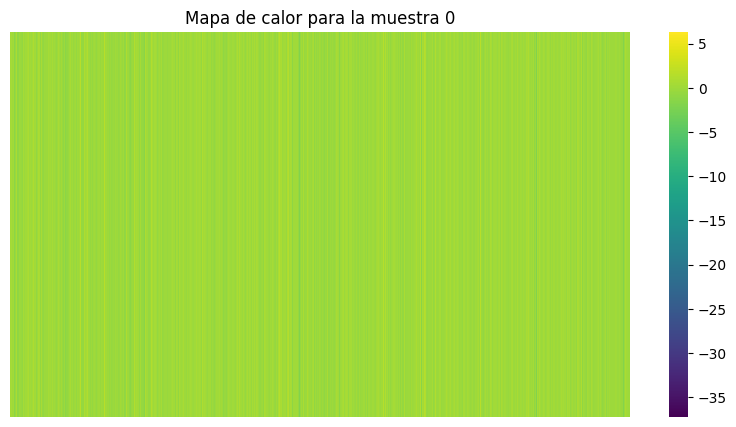

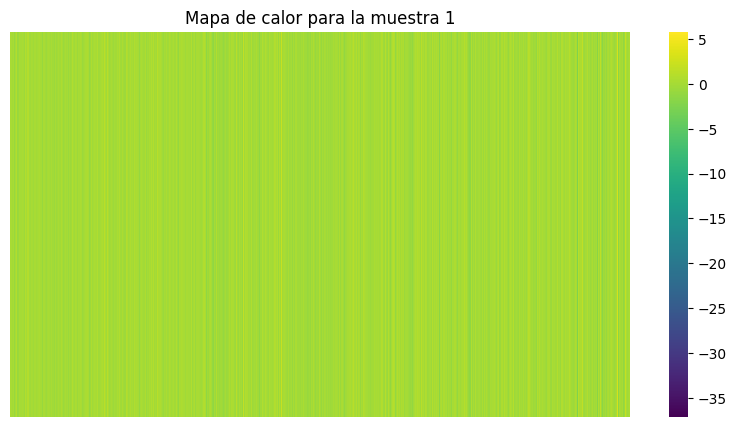

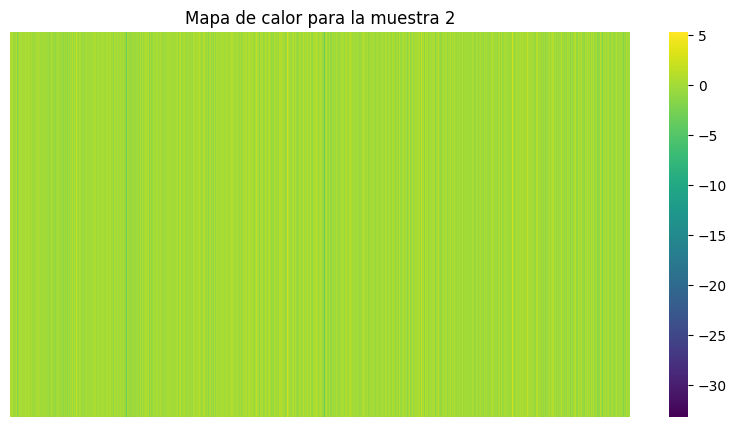

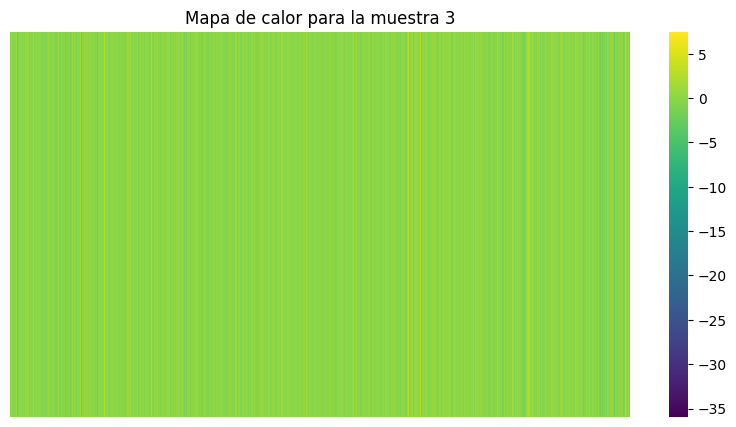

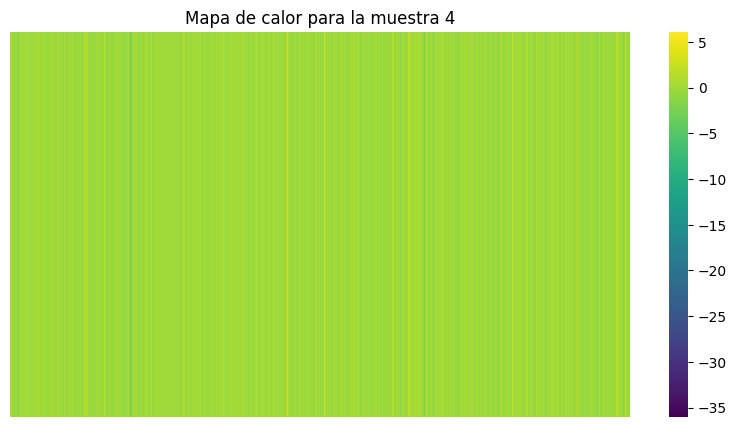

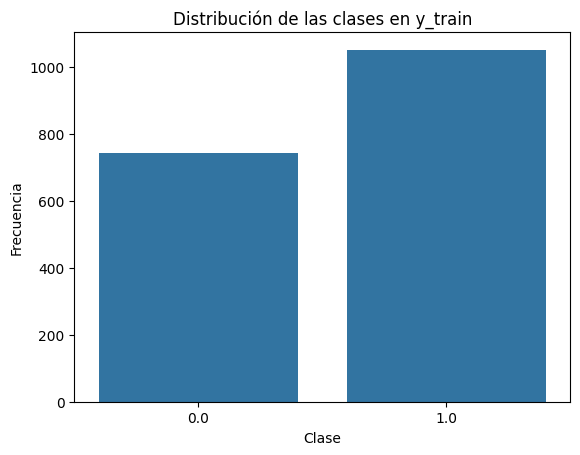

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
def plot_heatmap(data, index):
    sample = data[index].squeeze()  # Eliminar dimensiones extra
    plt.figure(figsize=(10, 5))
    sns.heatmap(sample.reshape(1, -1), cmap='viridis', cbar=True, xticklabels=False, yticklabels=False)
    plt.title(f'Mapa de calor para la muestra {index}')
    plt.show()

# Trazar mapas de calor para las primeras 5 muestras
for i in range(5):
    plot_heatmap(X_train, i)

# Distribución de las clases
def plot_class_distribution(y_train):
    sns.countplot(x=y_train)
    plt.title('Distribución de las clases en y_train')
    plt.xlabel('Clase')
    plt.ylabel('Frecuencia')
    plt.show()

# Mostrar la distribución de las clases
plot_class_distribution(y_train)